# EDA de Séries Temporais

Existem diversas formas de se analisar uma série temporal. Neste notebook, vamos explorar algumas delas.

Diferente de uma regressão linear, onde buscamos uma **interpolação** entre os dados, ou seja uma função que passe o mais próximo possível de todos os pontos, em uma série temporal buscamos uma **extrapolação**, ou seja, uma função que passe o mais próximo possível dos pontos já conhecidos e que seja capaz de prever os pontos futuros.

E dois pontos super importantes que nos permite fazer isso é a **autocorrelação** e a **autocorrelação parcial**.

A autocorrelação é a correlação de uma série temporal com ela mesma, mas com um *lag* (atraso) diferente. Por exemplo, a autocorrelação de lag 1 de uma série temporal $y_t$ é a correlação entre $y_t$ e $y_{t-1}$. Já a autocorrelação parcial é a correlação entre $y_t$ e $y_{t-1}$, mas removendo o efeito das correlações intermediárias. Por exemplo, a autocorrelação parcial de lag 3 de uma série temporal $y_t$ é a correlação entre $y_t$ e $y_{t-3}$ removendo o efeito das correlações intermediárias, ou seja, $y_{t-1}$ e $y_{t-2}$.

In [28]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Vamos importar o dataframe

In [3]:
df_path = 'https://raw.githubusercontent.com/carlosfab/datasets/master/electricity_consumption/Electric_Production.csv'
df = pl.read_csv(df_path)

df = df.select(
    pl.col('DATE').str.to_date('%m-%d-%Y').alias('date'),
    pl.col('Value').alias('value')
)

df.head(5)

date,value
date,f64
1985-01-01,72.5052
1985-02-01,70.672
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Vamos deixar nossa série estacionária como visto no primeiro notebook

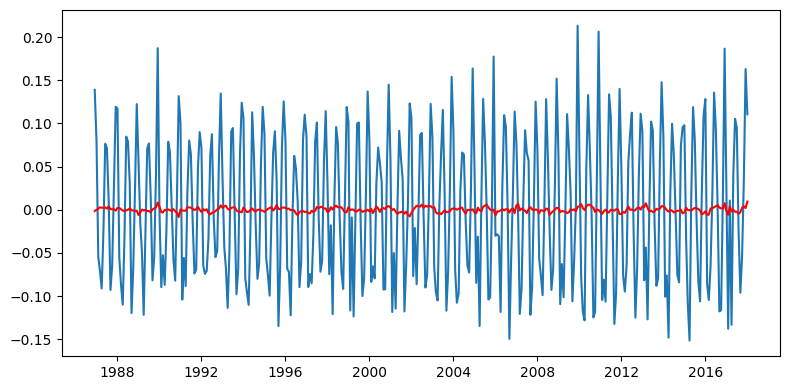

In [9]:
df_st = (
    df.with_columns(
        pl.col('value').log().alias('log_value')
    )
    .with_columns(
        pl.col('log_value').rolling_mean(12).alias('log_value_ma12')
    )
    .drop_nulls()
    .with_columns(
        (pl.col('log_value') - pl.col('log_value_ma12')).alias('sub_value')
    )
    .with_columns(
        pl.col('sub_value').diff(1).alias('diff_value')
    ).with_columns(
        pl.col('diff_value').rolling_mean(12).alias('diff_value_ma12')
    )
    .drop_nulls()
)

f, ax = plt.subplots(figsize=(8,4))

ax.plot(df_st['date'], df_st['diff_value'])
ax.plot(df_st['date'], df_st['diff_value_ma12'], color='red')

plt.tight_layout()

Agora vamos calcular a autocorrelação e a autocorrelação parcial

In [14]:
lag_acf = acf(df_st['diff_value'], nlags=25)
lag_pacf = pacf(df_st['diff_value'], nlags=25)

Vamos calcular os intervalos superiores e inferiores de confiança. Consideraremos 5% de significância.

Para calcular usaremos a formula:

$$IC = \pm \frac{1.96}{\sqrt{n-d}}$$

Onde $n$ é o tamanho da série e $d$ é o número de diferenciações.

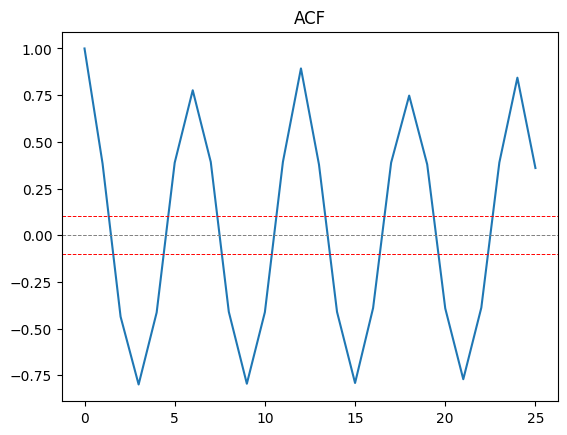

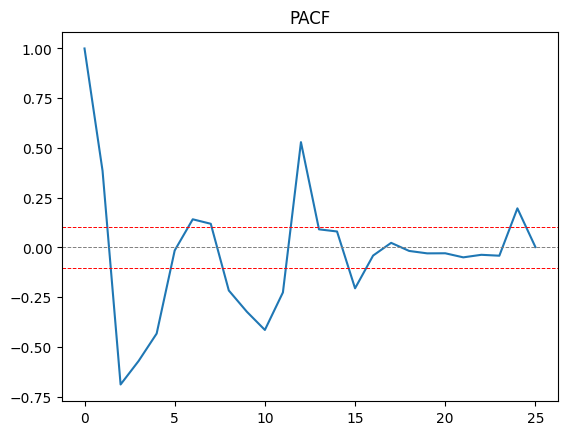

In [27]:
plt.plot(lag_acf)

plt.axhline(y = -1.96/np.sqrt(len(df_st['diff_value'])-1),linestyle='--',color='red', linewidth=.7)
plt.axhline(y = 0,linestyle='--',color='gray', linewidth=.7)
plt.axhline(y = 1.96/np.sqrt(len(df_st['diff_value'])-1),linestyle='--',color='red', linewidth=.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)

plt.axhline(y = -1.96/np.sqrt(len(df_st['diff_value'])-1),linestyle='--',color='red', linewidth=.7)
plt.axhline(y = 0,linestyle='--',color='gray', linewidth=.7)
plt.axhline(y = 1.96/np.sqrt(len(df_st['diff_value'])-1),linestyle='--',color='red', linewidth=.7)

plt.title('PACF')
plt.show()

Outra maneira de visualizar a autocorrelação é através do gráfico de autocorrelação (ACF) e o gráfico de autocorrelação parcial (PACF).

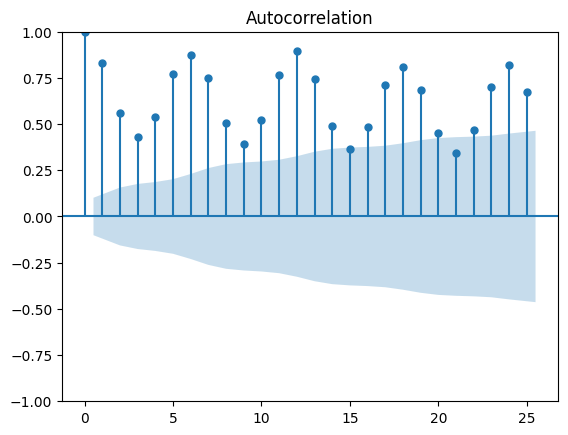

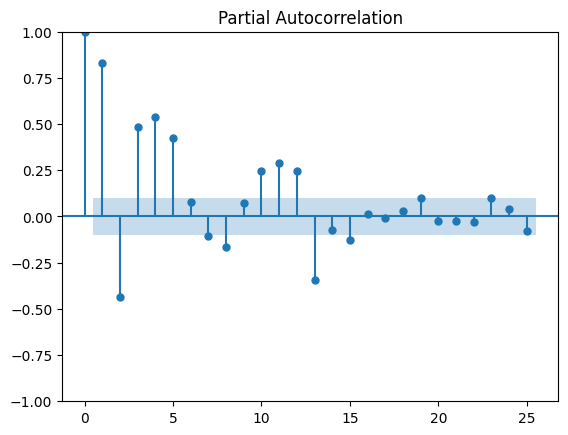

In [30]:
plot_acf(df_st['value'], lags=25)
plot_pacf(df_st['value'], lags=25);

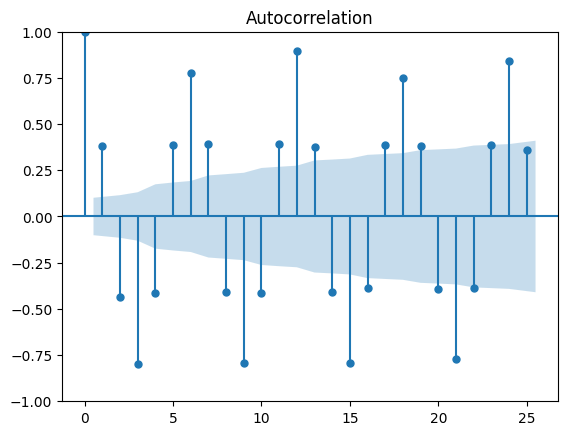

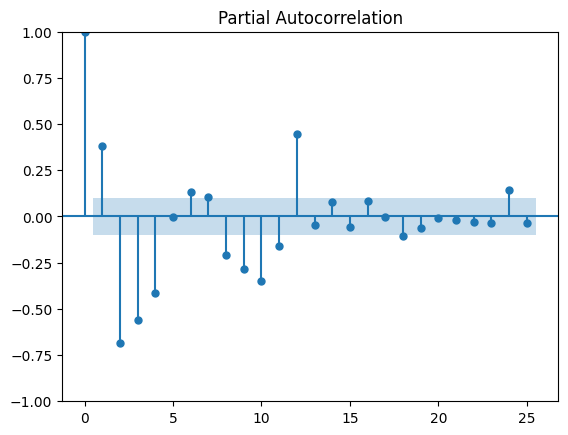

In [32]:
plot_acf(df_st['diff_value'], lags=25)
plot_pacf(df_st['diff_value'], lags=25);